In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')
from collections import defaultdict
from collections import  Counter
import re
import os
from tqdm import tqdm

#NLP
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

stop=set(stopwords.words('english'))

#tensorflow
import tensorflow
from tensorflow.python import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Loading the data

In [2]:
os.chdir("../input/nlp-getting-started")

In [3]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
submission=pd.read_csv("sample_submission.csv")

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print("train shape: "+str(train.shape))
print("test shape: "+str(test.shape))

train shape: (7613, 5)
test shape: (3263, 4)


# **EDA**

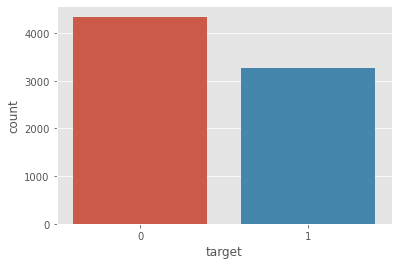

In [6]:
target=train.target
sns.countplot(target)

number of characters in tweets

Text(0.5, 1.0, 'non disaster tweets')

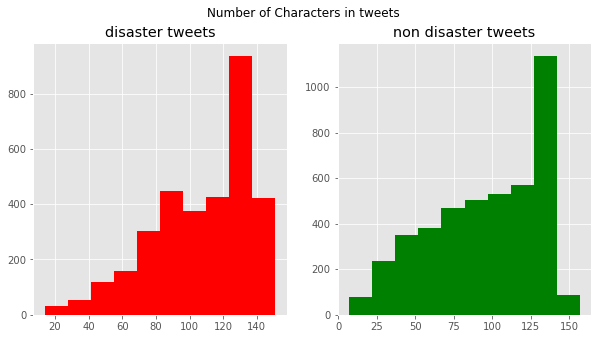

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Number of Characters in tweets')

tweet_len1=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len1, color='red')
ax1.set_title("disaster tweets")

tweet_len0=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len0, color='green')
ax2.set_title("non disaster tweets")

Text(0.5, 1.0, 'non disaster tweets')

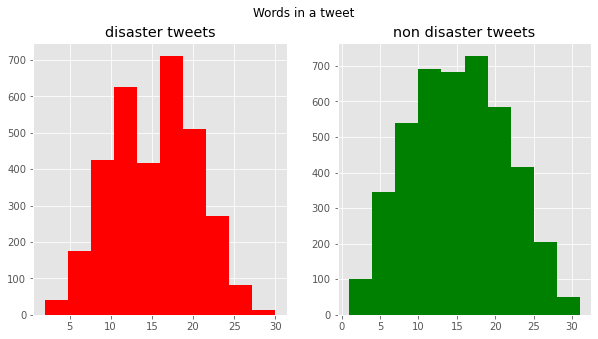

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Words in a tweet')

tweet_len1=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len1,color='red')
ax1.set_title('disaster tweets')

tweet_len0=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len0,color='green')
ax2.set_title('non disaster tweets')

In [9]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train["target"]==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

common stopwords in tweets

<BarContainer object of 10 artists>

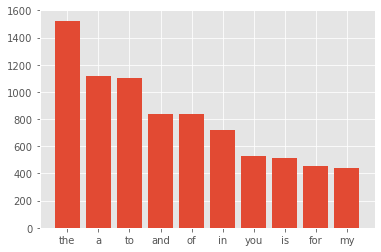

In [10]:
non_disaster_corpus=create_corpus(0)

count_dict=defaultdict(int)
for word in non_disaster_corpus:
    if word in stop:#stop=set(stopwords.words('english'))
        count_dict[word]+=1
        
top0=sorted(count_dict.items(), key=lambda x:x[1],reverse=True)[:10]
x0,y0=zip(*top0)
plt.bar(x0,y0)

<BarContainer object of 10 artists>

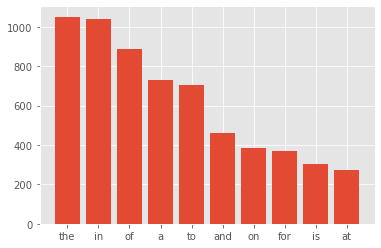

In [11]:
disaster_corpus=create_corpus(1)

count_dict=defaultdict(int)
for word in disaster_corpus:
    if word in stop:#stop=set(stopwords.words('english'))
        count_dict[word]+=1
        
top1=sorted(count_dict.items(), key=lambda x:x[1],reverse=True)[:10]
x1,y1=zip(*top1)
plt.bar(x1,y1)

analyzing punctuations

<BarContainer object of 20 artists>

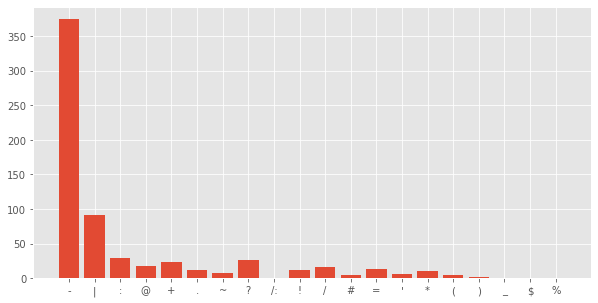

In [12]:
plt.figure(figsize=(10,5))
dic=defaultdict(int)
import string
special=string.punctuation

for i in (non_disaster_corpus):
    if i in special:
        dic[i]+=1

x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 18 artists>

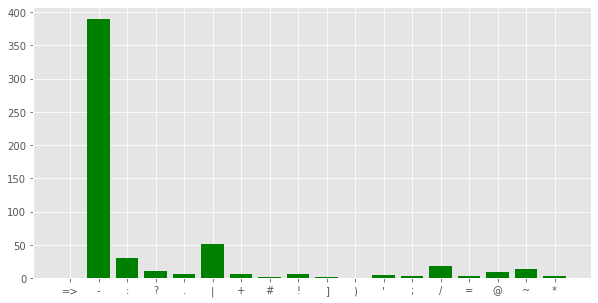

In [13]:
plt.figure(figsize=(10,5))
dic=defaultdict(int)
import string
special=string.punctuation

for i in (disaster_corpus):
    if i in special:
        dic[i]+=1

x,y=zip(*dic.items())
plt.bar(x,y,color="green")

what are the common words?

In [14]:
counter=Counter(disaster_corpus)
most=counter.most_common()
x=[]
y=[]
for word, count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

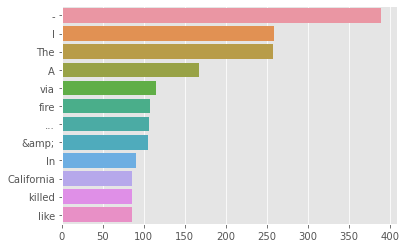

In [15]:
sns.barplot(x=y,y=x)

ngram analysis

In [16]:
#sklearnのcountVectorizerを使うとBoWの特徴量が簡単に作れる
def get_top_tweet_bigrams(corpus,n=None):
    vec=CountVectorizer(ngram_range=(2,2)).fit(corpus)#bigram
    bag_of_words=vec.transform(corpus)#scipyの疎な行列で返ってくる
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]#vec.vocabulary_は辞書で返ってくる. get_feature_names()はリストを返す
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

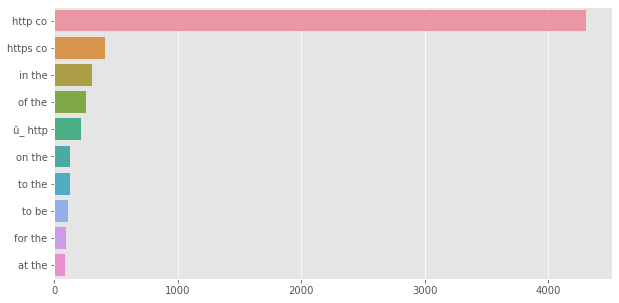

In [17]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(train["text"])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

Data Cleaning

In [18]:
df=pd.concat([train, test])
df.shape

(10876, 5)

removing urls

In [19]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

def remove_URL(text):
    url=re.compile(r'https?://\S+|www\.\S+')# \Sは全ての非空白文字, ? 0 or 1, + 1回以上
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [20]:
df['text']=df['text'].apply(lambda x: remove_URL(x))

In [21]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [22]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

removing punctuations

In [23]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    #複数の文字を変換・削除したかったら、str.replace()を使う
    #テーブルでは、　変換前文字列、変換後文字列、削除対象文字列
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [24]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 1.3 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [25]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me plese'

In [26]:
#df['text']=df['text'].apply(lambda x : correct_spellings(x)) 時間かかるからやらない

vectorization

In [27]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if ((word.isalpha()==True) & (word not in stop))]
        corpus.append(words)
    return corpus

In [28]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:03<00:00, 3071.94it/s]


In [29]:
#import pickle
#with open("../input/cprpus/corpus.pkl","wb") as f:
    #pickle.dump(corpus,f)
    
#import pickle
#corpus=[]
#with open("/kaggle/working/corpus.pkl", "rb") as f:
    #corpus=pickle.load(f)

↑のコードで保存したcorpusをダウンロードして使う

In [30]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index=tokenizer.word_index
print('Found %d unique tokens.' %len(word_index))

Found 18692 unique tokens.


In [31]:
sequences=tokenizer.texts_to_sequences(corpus)
data = pad_sequences(sequences, maxlen=30)
labels = train['target']

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (10876, 30)
Shape of label tensor: (7613,)


In [32]:
embedding_dict={}
with open("../glove6b/glove.6B.100d.txt",'r') as f:#スタンフォードのやつ。今回は100次元のものを使う
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:], 'float32')
        embedding_dict[word]=vectors
f.close()

In [33]:
num_words=len(word_index)+1
#initialize embedding matrix with zeros
embedding_matrix = np.zeros((num_words, 100)) #100次元まで落としこむ

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

100%|██████████| 18692/18692 [00:00<00:00, 244938.55it/s]


In [34]:
print(embedding_matrix.shape)

(18693, 100)


In [49]:
from keras.layers import Bidirectional

model=Sequential()
embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),input_length=30,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(8, dropout=0.2, recurrent_dropout=0.2,return_sequences=True)))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 100)           1869300   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 30, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 16)            6976      
_________________________________________________________________
lstm_16 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,882,581
Trainable params: 13,281
Non-trainable params: 1,869,300
_________________________________________________________________


In [51]:
def plot_learning_curve(history):
    fig,ax=plt.subplots(1,2,figsize=(20,10))
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [52]:
nlp_train = data[:len(train)]
nlp_test = data[len(train):]
X_train,X_test,y_train,y_test=train_test_split(nlp_train,train['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)


Shape of train (6471, 30)
Shape of Validation  (1142, 30)


In [ ]:
history=model.fit(X_train,y_train,validation_split=0.2,batch_size=16, epochs=25,verbose=0)

In [ ]:
plot_learning_curve(history)

In [ ]:
sample_sub=pd.read_csv('../nlp-getting-started/sample_submission.csv')

In [42]:
y_pre=model.predict(nlp_test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('/kaggle/working/submission#2.csv',index=False)

In [43]:
sub.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
